**Submit:**  Harel Cohen, Asaf Dahan, Noam Fradkin, Noy Nissim

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from os import listdir
from os.path import isfile, join
import re

In [ ]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import copy
plt.ion()   

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms

In [ ]:
!mkdir blood_cells

mkdir: cannot create directory ‘blood_cells’: File exists


In [ ]:
# Download our dataset and extract it
from zipfile import ZipFile

with ZipFile('./data.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path='./blood_cells/')

In [ ]:
images_path = './blood_cells/data/images' # edit with the path to your data
files = [join(images_path, f) for f in sorted(listdir(images_path)) if isfile(join(images_path, f))]

data = []

for file in files:
    img = plt.imread(file)
    transformed_img = torch.Tensor(img.reshape(3,256,256))
    data.append(transformed_img)

In [ ]:
labels_path = './blood_cells/data/labels' # edit with the path to your data
files = [join(labels_path, f) for f in sorted(listdir(labels_path)) if isfile(join(labels_path, f))]

labels = []

for file in files:
    label_img = plt.imread(file)
    label = np.sum(label_img)
    labels.append(int(label))

In [ ]:
train_data = data[:-20]
test_data = data[-20:]
train_labels = labels[:-20]
test_labels = labels[-20:]

In [ ]:
train_data = torch.stack(train_data)
test_data = torch.stack(test_data)
train_labels = torch.Tensor(train_labels)
test_labels = torch.Tensor(test_labels)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

In [ ]:
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
  }

In [ ]:
dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}
print('dataset_sizes: ', dataset_sizes)

dataset_sizes:  {'train': 180, 'val': 20}


In [ ]:
inputs, classes= next(iter(dataloaders['train']))
inputs.shape

torch.Size([16, 3, 256, 256])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),   
        )
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1048576 , 100), #first layer 100 neurons
            nn.ReLU(),
            nn.Linear(100, 20), #second layer 20 neurons
            nn.ReLU(),
            nn.Linear(20, 10), #third layer 10 elements
            nn.ReLU(),
            nn.Linear(10, 1)
        )


    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1048576, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [ ]:
from torchsummary import summary

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5         [-1, 64, 256, 256]          36,928
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
           Flatten-8              [-1, 1048576]               0
            Linear-9                  [-1, 100]     104,857,700
             ReLU-10                  [-1, 100]               0
           Linear-11                   [-1, 20]           2,020
             ReLU-12                   [-1, 20]               0
           Linear-13                   [-1, 10]             210
             ReLU-14                   

In [ ]:
# If a GPU is available, make the model use it
model = model.to(device)

criterion = nn.MSELoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
#optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
optimizer_ft = optim.Adam(model.parameters())


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 15

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_mae = np.inf
    results = {'loss_train':[], 'loss_val':[], 'mae_train':[], 'mae_val':[]}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0
            running_mae = 0.0
            running_mse = 0.0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    preds = model(inputs).reshape(-1,) # apply the model to the inputs. The output is the softmax probability of each class
                    loss = criterion(preds, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                error = torch.abs(preds - labels).sum().data
                running_mae += error
                squared_error = ((preds - labels)*(preds - labels)).sum().data
                running_mse += squared_error
                

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_mae = running_mae / dataset_sizes[phase]
            epoch_mse = running_mse / dataset_sizes[phase]

            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()
                results['loss_train'].append(epoch_loss)
                results['mae_train'].append(epoch_mae.item())
            
            else:
              results['loss_val'].append(epoch_loss)
              results['mae_val'].append(epoch_mae.item())

            print(f'{phase} Loss: {epoch_loss:.4f} MSE: {epoch_mse:.4f} MAE: {epoch_mae:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_mae < best_mae:
                best_mae = epoch_mae
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val MAE: {best_mae:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, results

In [ ]:
model, results = train_model(model, dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 15219.2569 MSE: 15219.2598 MAE: 104.0546
val Loss: 3600.6596 MSE: 3600.6599 MAE: 47.3838

Epoch 1/14
----------
train Loss: 1960.7814 MSE: 1960.7816 MAE: 35.6193
val Loss: 1796.1716 MSE: 1796.1718 MAE: 33.9098

Epoch 2/14
----------
train Loss: 968.3152 MSE: 968.3152 MAE: 25.3283
val Loss: 592.6785 MSE: 592.6785 MAE: 20.4291

Epoch 3/14
----------
train Loss: 327.9222 MSE: 327.9222 MAE: 14.8776
val Loss: 164.9644 MSE: 164.9644 MAE: 11.5553

Epoch 4/14
----------
train Loss: 68.9401 MSE: 68.9401 MAE: 6.6899
val Loss: 57.3978 MSE: 57.3978 MAE: 5.3374

Epoch 5/14
----------
train Loss: 51.1935 MSE: 51.1935 MAE: 5.6851
val Loss: 50.8492 MSE: 50.8492 MAE: 5.6988

Epoch 6/14
----------
train Loss: 64.3952 MSE: 64.3952 MAE: 6.5058
val Loss: 83.8538 MSE: 83.8538 MAE: 7.9436

Epoch 7/14
----------
train Loss: 49.2657 MSE: 49.2657 MAE: 5.6489
val Loss: 43.8899 MSE: 43.8899 MAE: 4.8386

Epoch 8/14
----------
train Loss: 42.3066 MSE: 42.3066 MAE: 5.1205
val Loss: 

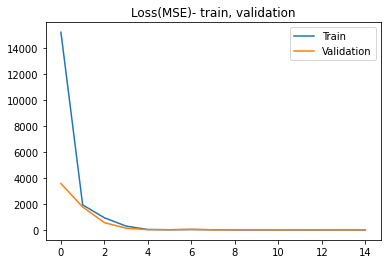

In [ ]:
plt.plot(results['loss_train'], label="Train")
plt.plot(results['loss_val'], label= "Validation")
plt.legend()
plt.title('Loss(MSE)- train, validation')
plt.show()

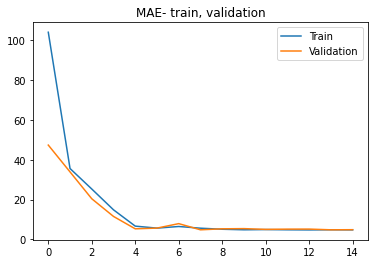

In [ ]:
plt.plot(results['mae_train'], label="Train")
plt.plot(results['mae_val'], label= "Validation")
plt.legend()
plt.title('MAE- train, validation')
plt.show()